# 전처리 및 변수선택 

In [2]:
# ======================================
# 1️⃣ 전처리 및 데이터 준비
# ======================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from itertools import combinations

# -------------------------
# 데이터 로드
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# 결측치 컬럼 제거
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# current_area 관련 변수 제거
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# 오타 수정
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# 범주형 변수 매핑 및 원-핫 인코딩
# -------------------------
# dance_years 매핑
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# 원-핫 인코딩
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, dtype=float)

# -------------------------
# 분석 제외 변수 제거
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# sat 변수 생성 및 이진 분류
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# 설명용 출력
# -------------------------
print("✅ 최종 데이터셋 컬럼 수:", df.shape[1])
print("sat 중위수:", sat_median)
print(df[['sat', 'sat_group']].head())


✅ 최종 데이터셋 컬럼 수: 183
sat 중위수: 4.0
    sat  sat_group
0  4.00          1
1  4.50          1
2  3.00          0
3  3.00          0
4  4.75          1


In [3]:
# ======================================
# 2️⃣ 변수 선택 (ElasticNet + RFECV)
# ======================================
X = df.drop(columns=['id','univ_proud','univ_belong','major_proud','major_belong','sat_group','sat'], errors='ignore')
y = df['sat_group']

n_repeat = 5  # 반복 횟수

# 선택 변수 저장
enet_selected_list = []
rfecv_lr_selected_list = []
rfecv_dt_selected_list = []
rfecv_rf_selected_list = []
rfecv_xgb_selected_list = []

for i in range(n_repeat):
    # -------------------------
    # ElasticNet (LogisticRegressionCV + l1+l2 규제 혼합)
    # -------------------------
    enet_clf = LogisticRegressionCV(
        penalty='elasticnet',
        solver='saga',            # elasticnet 가능 solver
        l1_ratios=[0.1,0.5,0.7,0.9,1],  # L1/L2 혼합 비율
        cv=5,                     # 내부 5-fold CV
        max_iter=2000,
        scoring='f1',
        random_state=i
    )
    enet_clf.fit(X, y)
    coefs = enet_clf.coef_[0]
    enet_selected_list.append(set(X.columns[coefs != 0]))

    # -------------------------
    # StratifiedKFold (RFECV용)
    # -------------------------
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

    # -------------------------
    # RFECV(LR)
    # -------------------------
    lr_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000, solver='liblinear', random_state=i))
    ])
    rfecv_lr = RFECV(
        estimator=lr_pipe,
        step=1,
        cv=cv,
        scoring='f1',
        min_features_to_select=5,
        n_jobs=-1,
        importance_getter='named_steps.lr.coef_'
    )
    rfecv_lr.fit(X, y)
    rfecv_lr_selected_list.append(set(X.columns[rfecv_lr.support_]))

    # -------------------------
    # RFECV(Decision Tree)
    # -------------------------
    dt = DecisionTreeClassifier(random_state=i)
    rfecv_dt = RFECV(estimator=dt, step=1, cv=cv,
                     scoring='f1', min_features_to_select=5, n_jobs=-1)
    rfecv_dt.fit(X, y)
    rfecv_dt_selected_list.append(set(X.columns[rfecv_dt.support_]))

    # -------------------------
    # RFECV(Random Forest)
    # -------------------------
    rf = RandomForestClassifier(random_state=i)
    rfecv_rf = RFECV(estimator=rf, step=1, cv=cv,
                     scoring='f1', min_features_to_select=5, n_jobs=-1)
    rfecv_rf.fit(X, y)
    rfecv_rf_selected_list.append(set(X.columns[rfecv_rf.support_]))

    # -------------------------
    # RFECV(XGBoost)
    # -------------------------
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=i)
    rfecv_xgb = RFECV(estimator=xgb, step=1, cv=cv,
                      scoring='f1', min_features_to_select=5, n_jobs=-1)
    rfecv_xgb.fit(X, y)
    rfecv_xgb_selected_list.append(set(X.columns[rfecv_xgb.support_]))

# -------------------------
# 반복 선택 변수 공통 (Jaccard 안정성 평가)
# -------------------------
def jaccard_index(list_of_sets):
    pairs = list(combinations(range(len(list_of_sets)), 2))
    scores = []
    for i,j in pairs:
        a,b = list_of_sets[i], list_of_sets[j]
        scores.append(len(a & b) / len(a | b) if len(a | b) > 0 else 0)
    return np.mean(scores)

enet_jaccard = jaccard_index(enet_selected_list)
rfecv_lr_jaccard = jaccard_index(rfecv_lr_selected_list)
rfecv_dt_jaccard = jaccard_index(rfecv_dt_selected_list)
rfecv_rf_jaccard = jaccard_index(rfecv_rf_selected_list)
rfecv_xgb_jaccard = jaccard_index(rfecv_xgb_selected_list)

print("🔹 평균 Jaccard 지수 (안정성 평가)")
print(f"ElasticNet: {enet_jaccard:.3f}")
print(f"RFECV(LR): {rfecv_lr_jaccard:.3f}")
print(f"RFECV(DT): {rfecv_dt_jaccard:.3f}")
print(f"RFECV(RF): {rfecv_rf_jaccard:.3f}")
print(f"RFECV(XGB): {rfecv_xgb_jaccard:.3f}")

# -------------------------
# 반복 공통 변수 도출
# -------------------------
enet_common = set.intersection(*enet_selected_list)
rfecv_lr_common = set.intersection(*rfecv_lr_selected_list)
rfecv_dt_common = set.intersection(*rfecv_dt_selected_list)
rfecv_rf_common = set.intersection(*rfecv_rf_selected_list)
rfecv_xgb_common = set.intersection(*rfecv_xgb_selected_list)


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: T

🔹 평균 Jaccard 지수 (안정성 평가)
ElasticNet: 1.000
RFECV(LR): 0.753
RFECV(DT): 0.293
RFECV(RF): 0.746
RFECV(XGB): 0.704


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [4]:
# ======================================
# 3️⃣ Cross-validated F1 평가
# ======================================
def cv_f1(X_subset, y, model, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    return cross_val_score(model, X_subset, y, cv=cv, scoring='f1').mean()

models = {
    "ElasticNet": LogisticRegressionCV(penalty='elasticnet', solver='saga', 
                                       l1_ratios=[0.5], cv=5, max_iter=2000),
    "RFECV(LR)": LogisticRegression(max_iter=1000, solver='liblinear'),
    "RFECV(DT)": DecisionTreeClassifier(),
    "RFECV(RF)": RandomForestClassifier(),
    "RFECV(XGB)": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

subset_dict = {
    "ElasticNet": list(enet_common),
    "RFECV(LR)": list(rfecv_lr_common),
    "RFECV(DT)": list(rfecv_dt_common),
    "RFECV(RF)": list(rfecv_rf_common),
    "RFECV(XGB)": list(rfecv_xgb_common)
}

for name, model in models.items():
    X_sub = X[subset_dict[name]]
    score = cv_f1(X_sub, y, model)
    print(f"{name} 최종 후보 변수 CV F1: {score:.3f}")

# ======================================
# 4️⃣ Hold-out/Test 성능 확인
# ======================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("🔹 Hold-out(Test) F1 Score")
for name, model in models.items():
    X_train_sub = X_train[subset_dict[name]]
    X_test_sub = X_test[subset_dict[name]]
    
    model.fit(X_train_sub, y_train)
    y_pred = model.predict(X_test_sub)
    score = f1_score(y_test, y_pred)
    
    print(f"{name}: {score:.3f}")

ElasticNet 최종 후보 변수 CV F1: 0.868
RFECV(LR) 최종 후보 변수 CV F1: 0.867
RFECV(DT) 최종 후보 변수 CV F1: 0.829
RFECV(RF) 최종 후보 변수 CV F1: 0.868


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

RFECV(XGB) 최종 후보 변수 CV F1: 0.864
🔹 Hold-out(Test) F1 Score
ElasticNet: 0.857
RFECV(LR): 0.879
RFECV(DT): 0.790
RFECV(RF): 0.886
RFECV(XGB): 0.867


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:40:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 ElasticNet 최적 파라미터 확인 (마지막 반복 기준)
최적 l1_ratio (α, L1/L2 혼합비): 0.7
최적 C (규제 강도 역수): 0.046415888336127774
최적 λ (alpha, 규제 강도): 21.544346900318843
후보 C 배열: [1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]
최적 α 인덱스: 2
최적 C 인덱스: 3


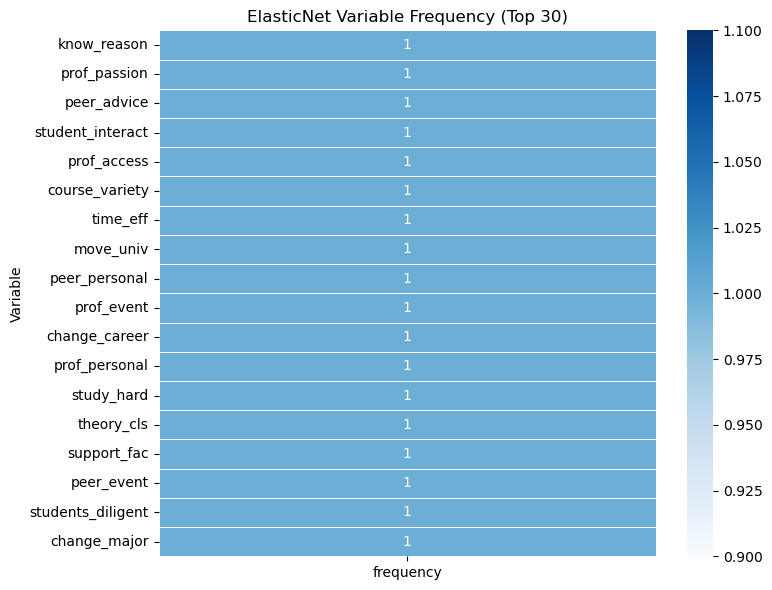

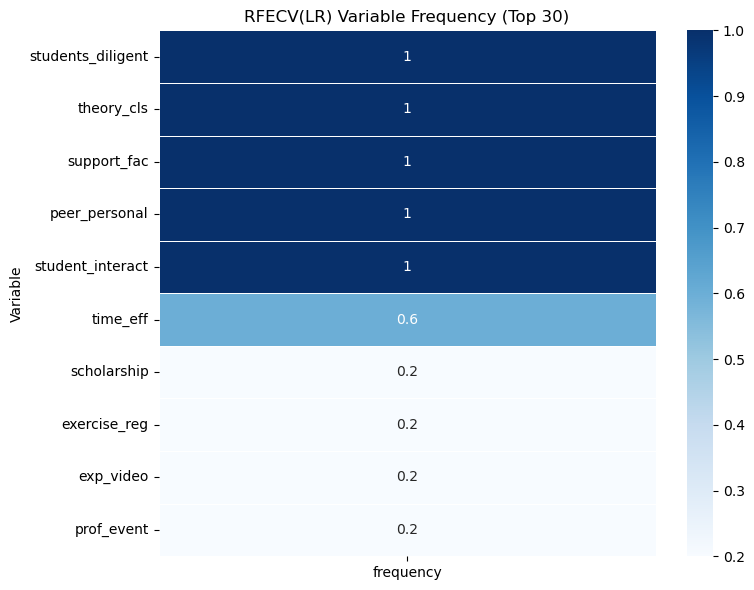

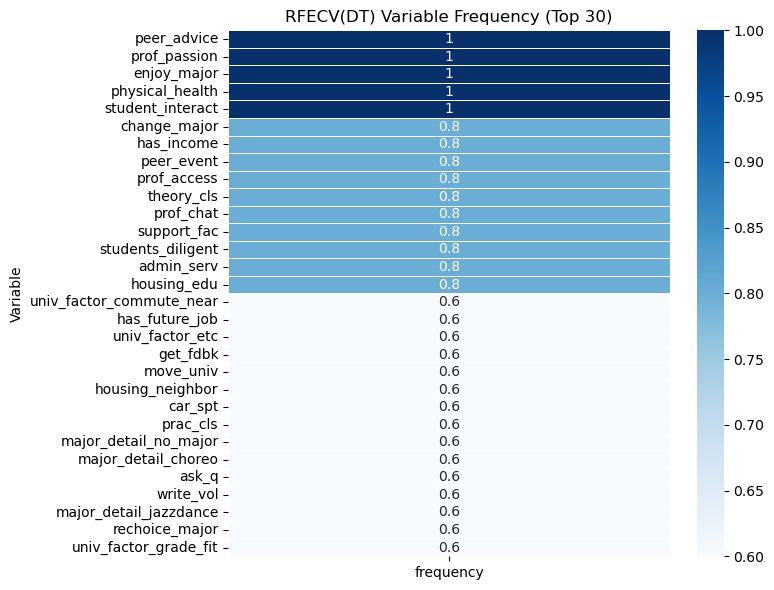

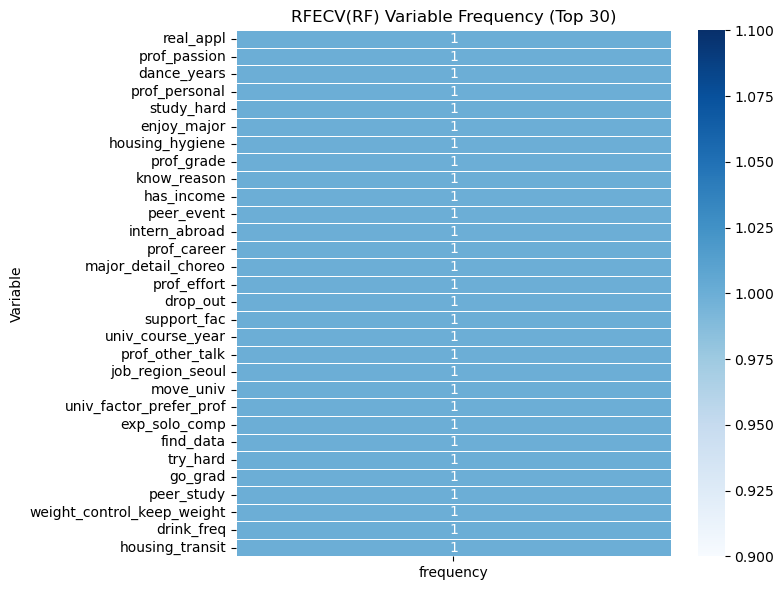

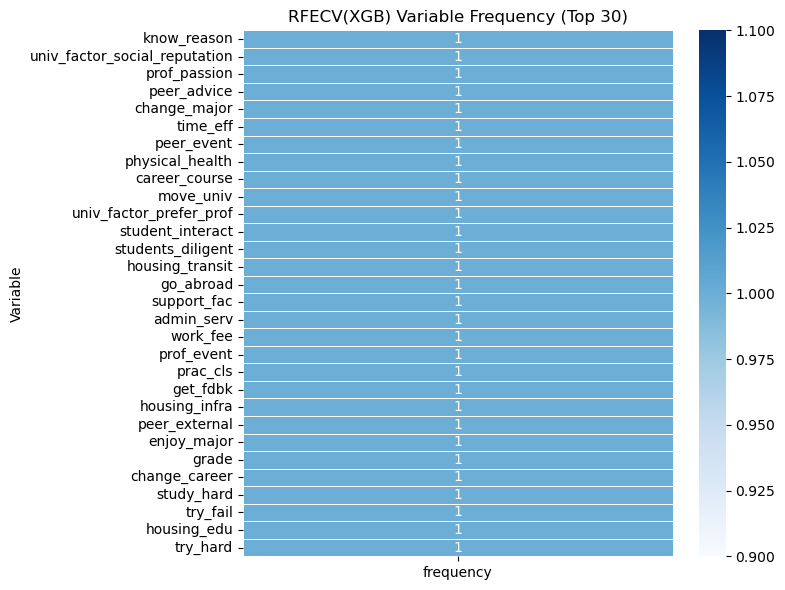

In [5]:
# ======================================
# 5️⃣ ElasticNet 최적 α / C 확인
# ======================================
# ⚠️ 주의: enet_clf는 반복 마지막 fold 기준
print("🔹 ElasticNet 최적 파라미터 확인 (마지막 반복 기준)")
print("최적 l1_ratio (α, L1/L2 혼합비):", enet_clf.l1_ratio_[0])
print("최적 C (규제 강도 역수):", enet_clf.C_[0])
print("최적 λ (alpha, 규제 강도):", 1/enet_clf.C_[0])  # λ = 1/C

# 후보 C 배열 확인
print("후보 C 배열:", enet_clf.Cs_)

# 최적 α / C 인덱스 확인
import numpy as np
optimal_C_index = np.where(enet_clf.Cs_ == enet_clf.C_[0])[0][0]
optimal_alpha_index = np.where(np.array(enet_clf.l1_ratios) == enet_clf.l1_ratio_[0])[0][0]
print("최적 α 인덱스:", optimal_alpha_index)
print("최적 C 인덱스:", optimal_C_index)

# ======================================
# 6️⃣ 반복 선택 변수 빈도 계산 및 시각화
# ======================================
import collections
import matplotlib.pyplot as plt
import seaborn as sns

def variable_frequency(selected_list, n_repeat=5):
    """
    반복 선택된 변수 리스트에서 빈도 계산
    selected_list: list of set
    n_repeat: 반복 횟수
    """
    counter = collections.Counter()
    for s in selected_list:
        counter.update(s)
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    freq_df['frequency'] = freq_df['count'] / n_repeat  # 선택 비율
    return freq_df.sort_values(by='frequency', ascending=False)

# 빈도 계산
enet_freq = variable_frequency(enet_selected_list, n_repeat)
rfecv_lr_freq = variable_frequency(rfecv_lr_selected_list, n_repeat)
rfecv_dt_freq = variable_frequency(rfecv_dt_selected_list, n_repeat)
rfecv_rf_freq = variable_frequency(rfecv_rf_selected_list, n_repeat)
rfecv_xgb_freq = variable_frequency(rfecv_xgb_selected_list, n_repeat)

# 히트맵 시각화
def plot_freq_heatmap(freq_df, title, top_n=30):
    top_vars = freq_df.head(top_n)
    plt.figure(figsize=(8,6))
    sns.heatmap(top_vars[['frequency']], annot=True, cmap='Blues', cbar=True, linewidths=0.5)
    plt.title(title)
    plt.ylabel('Variable')
    plt.tight_layout()
    plt.show()

# 상위 30개 변수 히트맵
plot_freq_heatmap(enet_freq, 'ElasticNet Variable Frequency (Top 30)')
plot_freq_heatmap(rfecv_lr_freq, 'RFECV(LR) Variable Frequency (Top 30)')
plot_freq_heatmap(rfecv_dt_freq, 'RFECV(DT) Variable Frequency (Top 30)')
plot_freq_heatmap(rfecv_rf_freq, 'RFECV(RF) Variable Frequency (Top 30)')
plot_freq_heatmap(rfecv_xgb_freq, 'RFECV(XGB) Variable Frequency (Top 30)')


In [14]:
# X의 전체 컬럼 확인
print("X 컬럼 수:", len(X.columns))
print(X.columns.tolist())

X 컬럼 수: 176
['univ_rank', 'major_rank', 'know_reason', 'prof_exp', 'study_hard', 'time_eff', 'edu_doubt', 'learn_fun', 'study_mate', 'try_hard', 'write_vol', 'find_data', 'self_study', 'try_fail', 'get_fdbk', 'real_appl', 'ask_q', 'fit_major', 'enjoy_major', 'cont_major', 'rechoice_major', 'move_univ', 'change_major', 'change_career', 'take_leave', 'drop_out', 'go_abroad', 'go_grad', 'work_fee', 'has_future_job', 'has_income', 'has_major_income', 'smoke_exp', 'drink_freq', 'exercise_reg', 'burnout', 'mental_health', 'physical_health', 'housing_infra', 'housing_transit', 'housing_safety', 'housing_hygiene', 'housing_green', 'housing_culture', 'housing_edu', 'housing_neighbor', 'move_for_univ', 'stay_after', 'lecture_fac', 'support_fac', 'scholarship', 'tuition', 'transport', 'prac_cls', 'theory_cls', 'prof_effort', 'lecture_qual', 'admin_serv', 'car_spt', 'intern_abroad', 'career_course', 'career_mentoring', 'job_test', 'job_prep', 'field_practice', 'abroad_practice', 'job_info', 'job_f

# 선택변수 기반 최적모델탐색  

In [29]:
# -------------------------
# 1️⃣ 변수 집합 정의
# -------------------------
subset_dict = {
    "ElasticNet_Common": list(enet_common),
    "RFECV_LR_Common": list(rfecv_lr_common)
}

# -------------------------
# 2️⃣ 모델 정의
# -------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# -------------------------
# 3️⃣ 모델 반복 평가
# -------------------------
results = []

for subset_name, subset_vars in subset_dict.items():
    print(f"\n🔹 변수 집합: {subset_name} ({len(subset_vars)}개 변수)")
    
    for model_name, model in models.items():
        # Logistic Regression만 Pipeline 적용
        use_pipe = True if model_name == "Logistic Regression" else False
        
        X_train_sub = X_train[subset_vars]
        X_test_sub = X_test[subset_vars]
        
        res = evaluate_model_updated_no_plot(
            X_train_sub, X_test_sub, y_train, y_test, 
            model, use_pipeline=use_pipe
        )
        
        results.append({
            "Variable_Set": subset_name,
            "Model": model_name,
            **res
        })

# -------------------------
# 4️⃣ 결과 DataFrame 출력
# -------------------------
results_df = pd.DataFrame(results)

# 보기 좋게 모델 이름 매핑
name_map = {
    "Logistic Regression": "Logistic Regression",
    "Decision Tree": "Decision Tree",
    "Random Forest": "Random Forest",
    "XGBoost": "XGBoost"
}
results_df["Model"] = results_df["Model"].map(name_map)

print("\n🔹 모든 모델 성능 요약 (CV + Test)")
print(results_df.round(3))



🔹 변수 집합: ElasticNet_Common (18개 변수)


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up


🔹 변수 집합: RFECV_LR_Common (5개 변수)


c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up


🔹 모든 모델 성능 요약 (CV + Test)
        Variable_Set                Model  CV_F1  CV_ACC  CV_AUC  \
0  ElasticNet_Common  Logistic Regression  0.852   0.821   0.900   
1  ElasticNet_Common        Decision Tree  0.791   0.743   0.727   
2  ElasticNet_Common        Random Forest  0.860   0.828   0.898   
3  ElasticNet_Common              XGBoost  0.863   0.831   0.894   
4    RFECV_LR_Common  Logistic Regression  0.866   0.831   0.902   
5    RFECV_LR_Common        Decision Tree  0.779   0.743   0.760   
6    RFECV_LR_Common        Random Forest  0.831   0.799   0.867   
7    RFECV_LR_Common              XGBoost  0.823   0.792   0.860   

   CV_Precision  CV_Recall  Test_F1  Test_ACC  Test_AUC  Test_Precision  \
0         0.846      0.860    0.857     0.831     0.905           0.878   
1         0.781      0.802    0.819     0.789     0.788           0.850   
2         0.843      0.877    0.897     0.873     0.910           0.886   
3         0.844      0.884    0.840     0.817     0.912     

c:\Users\SAMSUNG\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


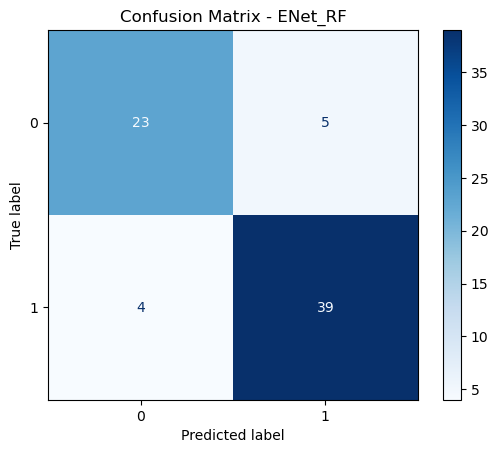

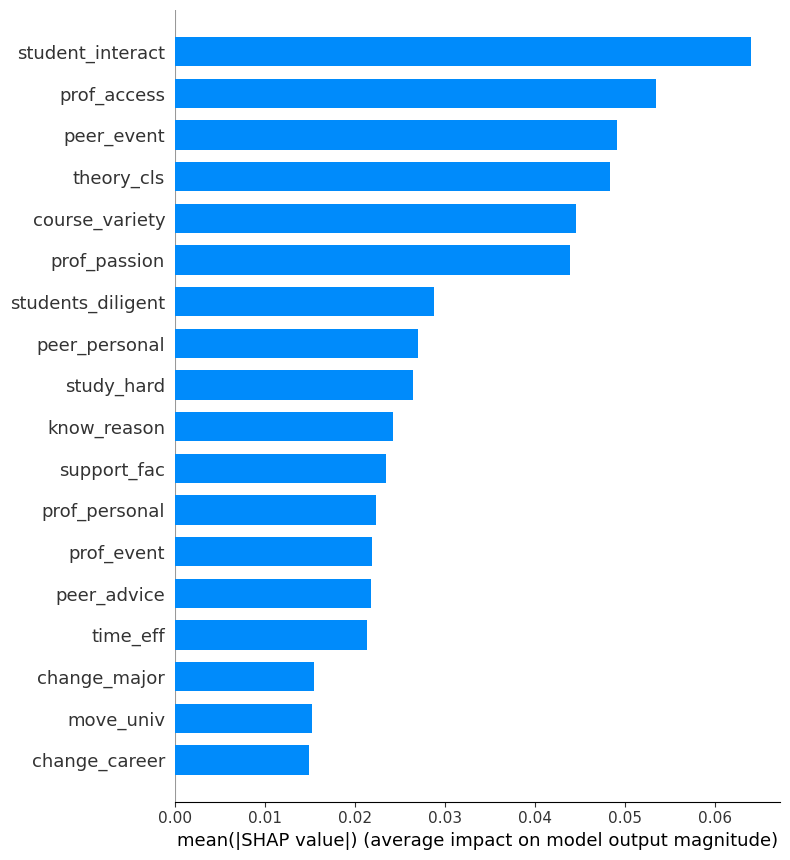

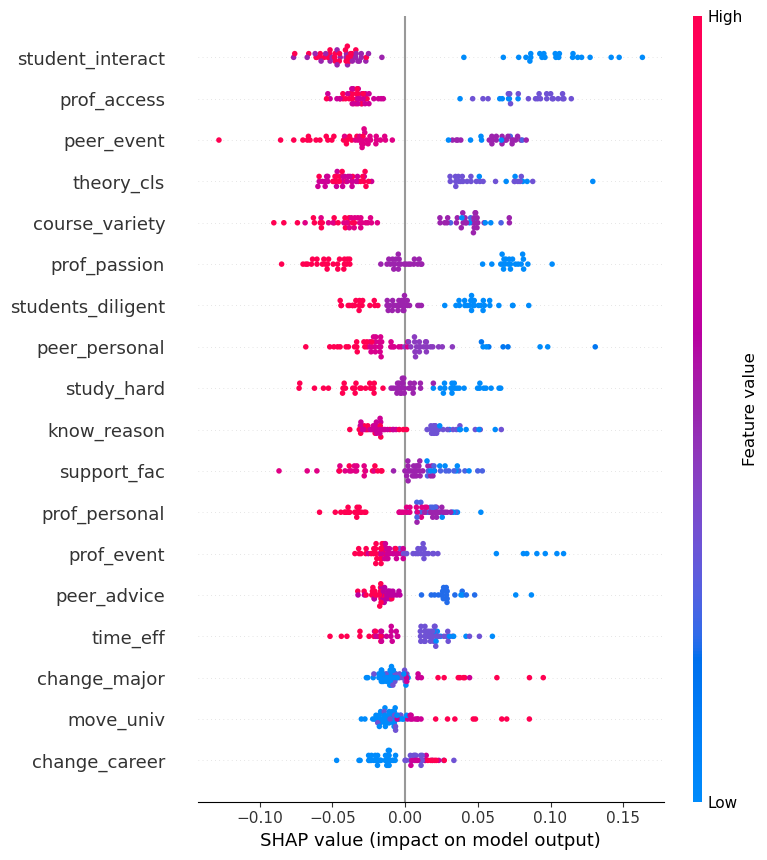


🔹 ENet_RF SHAP Importance (mean / mean_abs)


,feature,shap_mean,shap_mean_abs
0,student_interact,0.002831,0.064060
14,prof_access,0.012301,0.053456
2,peer_event,0.001131,0.049097
4,theory_cls,-0.001326,0.048410
13,course_variety,-0.001896,0.044578
12,prof_passion,0.003152,0.043882
17,students_diligent,0.009085,0.028799
9,peer_personal,-0.000185,0.027016
5,study_hard,0.000380,0.026492
1,know_reason,0.000732,0.024267


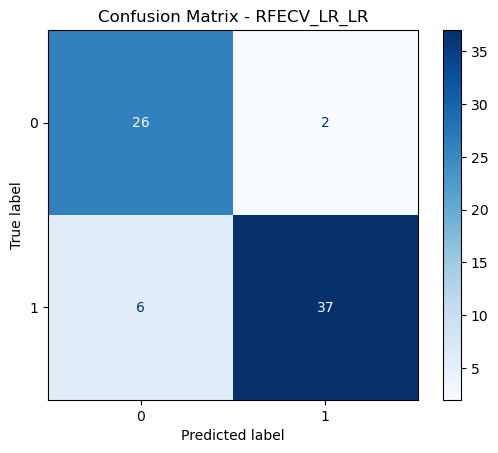

c:\Users\SAMSUNG\anaconda3\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


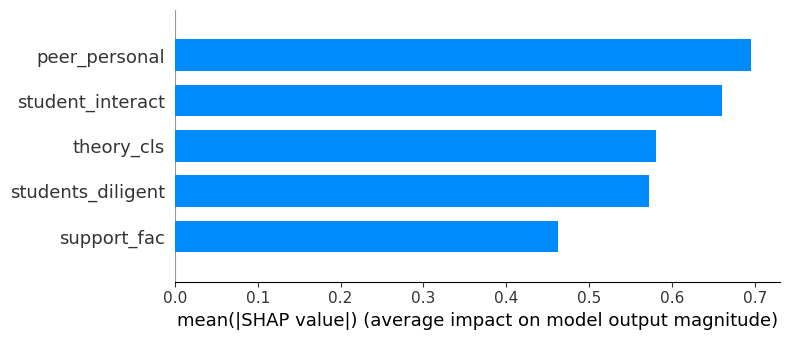

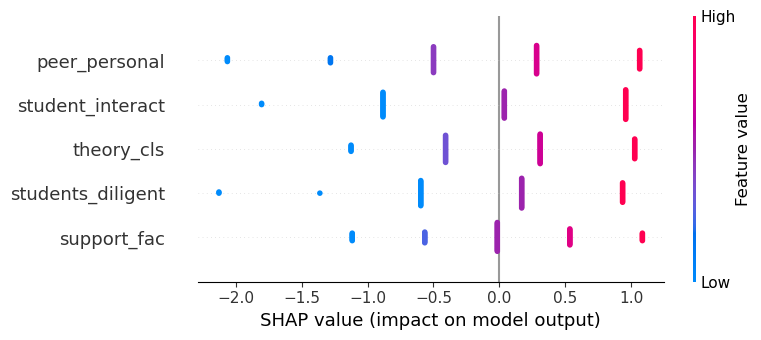


🔹 RFECV_LR_LR SHAP Importance (mean / mean_abs)


,feature,shap_mean,shap_mean_abs
2,peer_personal,-0.026840,0.695648
3,student_interact,0.036786,0.660590
1,theory_cls,0.126451,0.581191
4,students_diligent,0.028219,0.572772
0,support_fac,0.022219,0.462104


         Model  CV_F1  CV_Precision  CV_Recall  CV_AUC  Test_F1  Test_ACC  \
0      ENet_RF  0.860         0.843      0.877   0.898    0.897     0.873   
1  RFECV_LR_LR  0.866         0.840      0.896   0.902    0.902     0.887   

   Test_Precision  Test_Recall  Test_AUC    Confusion_Matrix  
0           0.886        0.907     0.910  [[23, 5], [4, 39]]  
1           0.949        0.860     0.949  [[26, 2], [6, 37]]  


In [34]:
# ======================================
# 🔹 관심 모델만 CV + Test 성능 + Confusion Matrix + SHAP
# ======================================
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (f1_score, accuracy_score, precision_score,
                             recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# -------------------------
# 관심 모델 정의
# -------------------------
subset_models = {
    "ENet_RF": RandomForestClassifier(random_state=42),          # ElasticNet 후보 변수 → RF
    "RFECV_LR_LR": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)  # RFECV(LR) 후보 변수 → LR
}

subset_X_train = {
    "ENet_RF": X_train[list(enet_common)],
    "RFECV_LR_LR": X_train[list(rfecv_lr_common)]
}

subset_X_test = {
    "ENet_RF": X_test[list(enet_common)],
    "RFECV_LR_LR": X_test[list(rfecv_lr_common)]
}

# -------------------------
# 결과 저장
# -------------------------
results_list = []
shap_results = {}

for name, model in subset_models.items():
    X_tr = subset_X_train[name]
    X_te = subset_X_test[name]

    # Logistic Regression은 Pipeline 적용
    use_pipe = True if "LR" in name else False
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)]) if use_pipe else model

    # -------------------------
    # CV 성능
    # -------------------------
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_f1 = cross_val_score(pipe, X_tr, y_train, cv=cv, scoring='f1').mean()
    cv_precision = cross_val_score(pipe, X_tr, y_train, cv=cv, scoring='precision').mean()
    cv_recall = cross_val_score(pipe, X_tr, y_train, cv=cv, scoring='recall').mean()
    cv_auc = cross_val_score(pipe, X_tr, y_train, cv=cv, scoring='roc_auc').mean()

    # -------------------------
    # Hold-out(Test) 성능
    # -------------------------
    pipe.fit(X_tr, y_train)
    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:,1] if hasattr(pipe, "predict_proba") else None

    test_f1 = f1_score(y_test, y_pred)
    test_acc = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)

    # -------------------------
    # Confusion Matrix 시각화
    # -------------------------
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=pipe.named_steps['clf'].classes_ if use_pipe else model.classes_)
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # -------------------------
    # SHAP 계산
    # -------------------------
    if isinstance(model, RandomForestClassifier):
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer(X_te)
        shap_array = shap_vals.values
    elif isinstance(model, LogisticRegression):
        explainer = shap.LinearExplainer(pipe.named_steps['clf'],
                                         pipe.named_steps['scaler'].transform(X_tr),
                                         feature_perturbation="interventional")
        shap_vals = explainer(pipe.named_steps['scaler'].transform(X_te))
        shap_array = shap_vals.values
    else:
        raise ValueError(f"Unsupported model type: {type(model)}")

    # -------------------------
    # SHAP array 차원 처리
    # -------------------------
    if shap_array.ndim == 3:
        shap_array = shap_array[:, :, 0]  # (samples, features, 1) -> (samples, features)
    elif shap_array.ndim != 2:
        raise ValueError(f"Unexpected SHAP array shape: {shap_array.shape}")

    # -------------------------
    # SHAP DataFrame
    # -------------------------
    shap_df = pd.DataFrame({
        "feature": X_te.columns,
        "shap_mean": shap_array.mean(axis=0),
        "shap_mean_abs": np.abs(shap_array).mean(axis=0)
    }).sort_values(by="shap_mean_abs", ascending=False)

    shap_results[name] = shap_df

    # SHAP Summary Plot
    plt.figure()
    shap.summary_plot(shap_array, X_te, plot_type="bar", show=True)
    plt.figure()
    shap.summary_plot(shap_array, X_te, plot_type="dot", show=True)
    print(f"\n🔹 {name} SHAP Importance (mean / mean_abs)")
    display(shap_df)

    # -------------------------
    # 결과 저장
    # -------------------------
    results_list.append({
        "Model": name,
        "CV_F1": cv_f1, "CV_Precision": cv_precision, "CV_Recall": cv_recall, "CV_AUC": cv_auc,
        "Test_F1": test_f1, "Test_ACC": test_acc, "Test_Precision": test_precision,
        "Test_Recall": test_recall, "Test_AUC": test_auc, "Confusion_Matrix": cm.tolist()
    })

# -------------------------
# 최종 결과 DataFrame
# -------------------------
comparison_df = pd.DataFrame(results_list)
print(comparison_df.round(3))


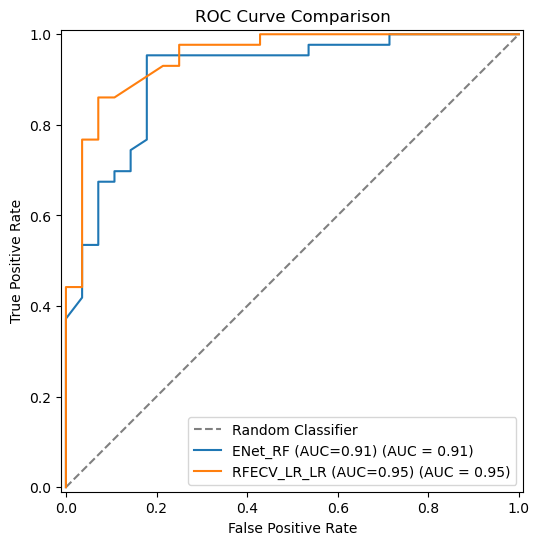

In [38]:
plt.figure(figsize=(8,6))
ax = plt.gca()  # 현재 axes 가져오기

# ROC 기준선
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")

# 모델 ROC
for name, model in subset_models.items():
    X_tr = subset_X_train[name]
    X_te = subset_X_test[name]

    use_pipe = True if "LR" in name else False
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)]) if use_pipe else model
    pipe.fit(X_tr, y_train)

    y_proba = pipe.predict_proba(X_te)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_proba, name=f"{name} (AUC={roc_auc_score(y_test, y_proba):.2f})", ax=ax)

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
